# Self-Organizing Map (Kohonen Network) for financial data

The goal is to use a Self-Organizing Map as an unsupervised learning method to discover typical Japanese candlestick patterns in financial time series data. We will use OHLC EUR/USD data starting from 4 January 2010. Data source: https://stooq.pl

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
EPS = 1e-12

In [69]:
df = pd.read_csv("data/eurusd_d.csv")
cols = {c: c.strip().lower() for c in df.columns}
df = df.rename(columns=cols)
df["date"] = pd.to_datetime(df["date"])
df.head()

,date,open,high,low,close
0,2010-01-04,1.4325,1.4455,1.4257,1.4412
1,2010-01-05,1.4409,1.4482,1.4348,1.4361
2,2010-01-06,1.4362,1.4434,1.4284,1.4399
3,2010-01-07,1.4400,1.4447,1.4301,1.4304
4,2010-01-08,1.4304,1.4438,1.4263,1.4398


Before training the network, the OHLC data is transformed into a numerical representation suitable for neural network processing.  
Each candlestick is converted into a feature vector describing its geometric shape: body, wicks, and closing position. Then, it is normalized by the candle range in order to remove price scale effects.

In [70]:
def candle_features(df):
    open_f = df["open"].to_numpy(float)
    high_f = df["high"].to_numpy(float)
    low_f = df["low"].to_numpy(float)
    close_f = df["close"].to_numpy(float)

    hl_diff = np.maximum(high_f - low_f, EPS)
    body = close_f - open_f
    upper = high_f - np.maximum(open_f, close_f)
    lower = np.minimum(open_f, close_f) - low_f
    pos = (close_f - low_f) / hl_diff

    body_n = body / hl_diff
    upper_n = upper / hl_diff
    lower_n = lower / hl_diff
    direction = np.sign(body)

    X = np.column_stack([body_n, upper_n, lower_n, pos, direction])
    return X

def window_stack(X, k):
    # (t, dim) -> (t-k+1, k*dim)
    if k <= 1:
        return X
    T, d = X.shape
    out = np.hstack([X[i:T-k+1+i] for i in range(k)])
    return out

def l2norm_rows(A):
    n = np.linalg.norm(A, axis=1, keepdims=True)
    return A / np.maximum(n, EPS)

In [83]:
X = candle_features(df)
WINDOW = 1
Xw = window_stack(X, WINDOW)
Xn = l2norm_rows(Xw)
Xn

array([[ 0.313 ,  0.1547,  0.2446,  0.5576,  0.7123],
       [-0.2981,  0.4534,  0.0807,  0.0807, -0.8322],
       [ 0.1756,  0.1661,  0.3702,  0.5457,  0.7118],
       ...,
       [-0.4575,  0.0046,  0.3108,  0.3108, -0.773 ],
       [ 0.107 ,  0.2123,  0.4028,  0.5098,  0.7221],
       [-0.6888,  0.0353,  0.    ,  0.    , -0.7241]], shape=(4164, 5))

In [84]:
class SelfOrganizingMap:
    def __init__(self, m, n, dim, seed=0):
        self.m, self.n, self.dim = m, n, dim
        rng = np.random.default_rng(seed)
        W = rng.normal(size=(m*n, dim))
        self.W = W / np.linalg.norm(W, axis=1, keepdims=True)
        self.coords = np.array([(i, j) for i in range(m) for j in range(n)], dtype=float)

    def bmu(self, x: np.ndarray) -> int:
        sims = self.W @ x
        return int(np.argmax(sims))

    def train(self, X: np.ndarray, epochs=20, lr0=0.4, sigma0=None, seed=0):
        if sigma0 is None:
            sigma0 = max(self.m, self.n) / 2.0

        rng = np.random.default_rng(seed)
        T = epochs * len(X)
        t = 0

        for ep in range(epochs):
            for i in rng.permutation(len(X)):
                x = X[i]
                b = self.bmu(x)

                lr = lr0 * (1 - t / T)
                sigma = sigma0 * (1 - t / T)
                sigma = max(sigma, 1e-3)

                d = np.linalg.norm(self.coords - self.coords[b], axis=1)
                h = np.exp(-(d**2) / (2 * sigma**2))

                self.W += (lr * h)[:, None] * (x - self.W)
                self.W /= np.linalg.norm(self.W, axis=1, keepdims=True)
                t += 1

    def map_samples(self, X: np.ndarray) -> np.ndarray:
        return np.array([self.bmu(x) for x in X], dtype=int)

In [85]:
som = SelfOrganizingMap(m=10, n=10, dim=Xn.shape[1], seed=42)
som.train(Xn, epochs=100, lr0=0.1, sigma0=3.0, seed=42)

Now train the network to assign each input vector to its best matching unit. To visualize the learned structure, the number of samples mapped to each neuron is counted, producing a 10x10 occupancy matrix that shows how frequently different candlestick patterns occur in the dataset.


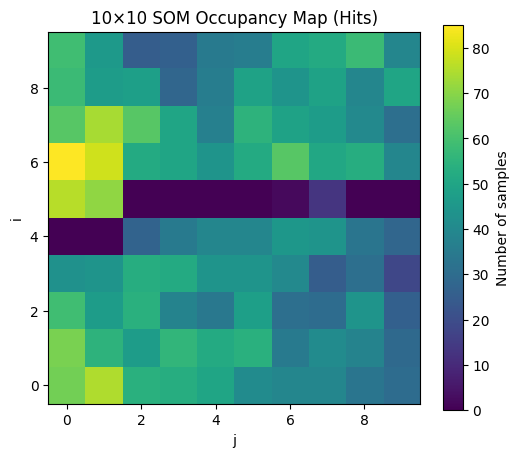

Number of non-empty neurons: 92 out of 100


In [86]:
bmus = som.map_samples(Xn)
counts = np.bincount(bmus, minlength=100).reshape(10,10)

plt.figure(figsize=(6,5))
plt.imshow(counts, origin="lower")
plt.colorbar(label="Number of samples")
plt.title("10×10 SOM Occupancy Map (Hits)")
plt.xlabel("j")
plt.ylabel("i")
plt.show()

print("Number of non-empty neurons:", np.count_nonzero(counts), "out of", counts.size)


The occupancy map shows that most neurons are actively used, indicating good coverage of the input space. Regions with higher counts correspond to frequently occurring candlestick patterns, while empty or sparsely populated neurons represent rare or extreme patterns.

Additionally, let's visualize distances between neighboring neurons (U-matrix), highlighting cluster boundaries in the SOM. Brighter regions indicate cluster boundaries, while darker areas correspond to groups of similar candlestick patterns.

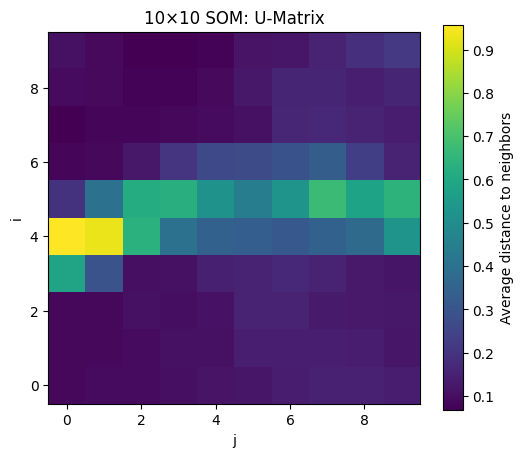

In [87]:
def u_matrix(W, m, n) -> np.ndarray:
    Wg = W.reshape(m, n, -1)
    U = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            neighbors = []
            if i > 0:
                neighbors.append(Wg[i-1, j])
            if i < m-1:
                neighbors.append(Wg[i+1, j])
            if j > 0:
                neighbors.append(Wg[i, j-1])
            if j < n-1:
                neighbors.append(Wg[i, j+1])
            if neighbors:
                distances = [np.linalg.norm(Wg[i, j] - v) for v in neighbors]
                U[i, j] = np.mean(distances)
    return U

U = u_matrix(som.W, 10, 10)

plt.figure(figsize=(6, 5))
plt.imshow(U, origin="lower")
plt.colorbar(label="Average distance to neighbors")
plt.title("10×10 SOM: U-Matrix")
plt.xlabel("j")
plt.ylabel("i")
plt.show()

There is a clear vertical line around i = 4 and i = 5, which indicates a strong separation between two regions of the map. The SOM has learned at least two distinct groups of candlestick patterns that differ significantly in shape. To validate the SOM results, we can plot a few candlesticks with the highest similarity for the most frequently activated neurons.

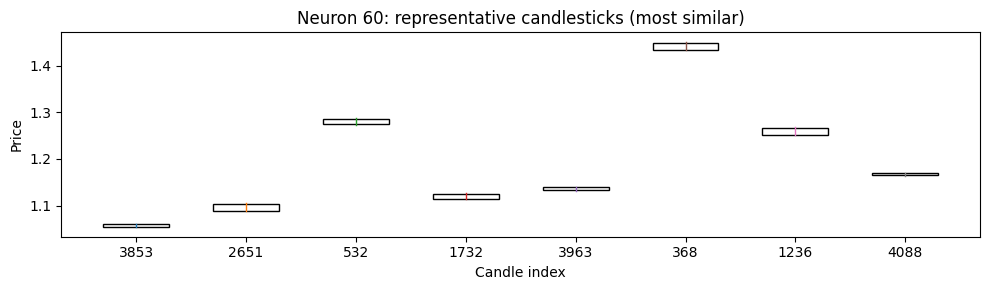

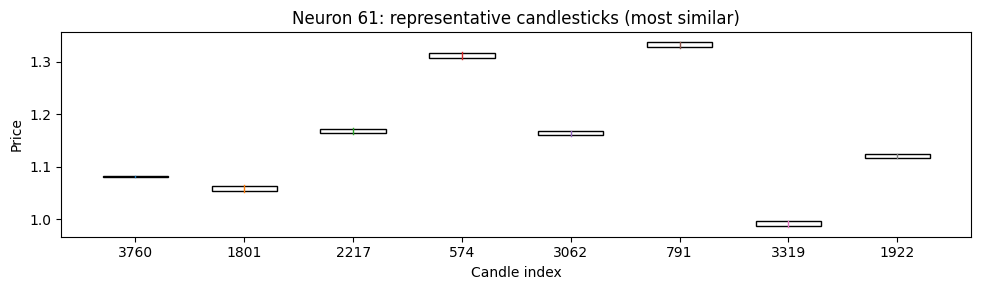

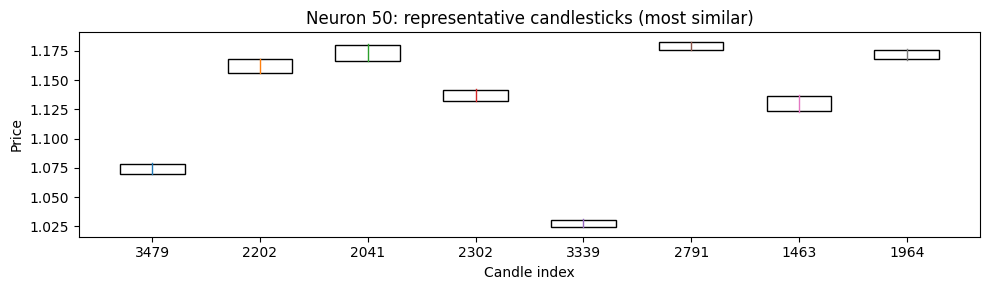

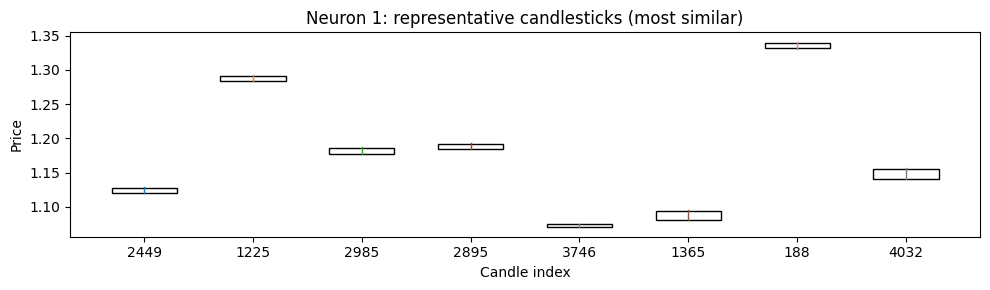

In [90]:
def top_examples_for_neuron(neuron_id, Xn, W, bmus, k=5):
    idx = np.where(bmus == neuron_id)[0]
    if len(idx) == 0:
        return np.array([], dtype=int)
    sims = Xn[idx] @ W[neuron_id]
    return idx[np.argsort(-sims)[:k]]

def plot_candles(df, idxs, title=""):
    o = df["open"].to_numpy(float)
    h = df["high"].to_numpy(float)
    l = df["low"].to_numpy(float)
    c = df["close"].to_numpy(float)

    plt.figure(figsize=(10, 3))
    for t, i in enumerate(idxs):
        plt.plot([t, t], [l[i], h[i]], linewidth=1)
        y0, y1 = o[i], c[i]
        lo, hi = min(y0, y1), max(y0, y1)
        plt.gca().add_patch(
            plt.Rectangle((t - 0.3, lo), 0.6, max(hi - lo, 1e-6), fill=False)
        )

    plt.title(title)
    plt.xticks(range(len(idxs)), [str(i) for i in idxs], rotation=0)
    plt.xlabel("Candle index")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()

flat = counts.ravel()
top_neurons = np.argsort(-flat)[:4]
for nid in top_neurons:
    ex = top_examples_for_neuron(int(nid), Xn, som.W, bmus, k=8)
    if len(ex) == 0:
        continue
    if WINDOW == 1:
        plot_candles(
            df, ex,
            title=f"Neuron {nid}: representative candlesticks (most similar)"
        )
    else:
        plot_candles(
            df, ex,
            title=f"Neuron {nid}: representative examples (first candle of window)"
        )


The plotted candlesticks assigned to the same neuron show some pattern in terms of body size and wick structure. Although differences between neurons are often subtle, this visualization still confirms that the SOM clusters candlesticks are based on shape similarity.